<a href="https://colab.research.google.com/github/dunliangyang2010/AutoKeras/blob/main/Multitask_IMDB_Sentiment_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip3 install autokeras

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import autokeras as ak

In [7]:
# 匯入資料,同時預測IMDB分數及正負面評價
df = pd.read_csv('https://github.com/alankrantas/IMDB-movie-reviews-with-ratings_dataset/raw/main/imdb_sup.csv')
df

,Review,Rating,Sentiment
0,"Kurt Russell's chameleon-like performance, cou...",10,1
1,It was extremely low budget(it some scenes it ...,8,1
2,James Cagney is best known for his tough chara...,8,1
3,"Following the brilliant ""Goyôkiba"" (aka. ""Hanz...",8,1
4,One of the last classics of the French New Wav...,10,1
...,...,...,...
49995,(spoiler) it could be the one the worst movie ...,4,0
49996,"So, you've seen the Romero movies, yes? And yo...",1,0
49997,Just listen to the Broadway cast album and to ...,3,0
49998,I have been a fan of the Carpenters for a long...,3,0


In [8]:
from sklearn.model_selection import train_test_split

data, test = train_test_split(df, test_size=0.2, random_state=42)

x_train = data['Review'].to_numpy()
y_rating_train = data['Rating'].to_numpy()
y_sentiment_train = data['Sentiment'].to_numpy()

x_test = test['Review'].to_numpy()
y_rating_test = test['Rating'].to_numpy()
y_sentiment_test = test['Sentiment'].to_numpy()

# Model

In [10]:
input_node = ak.TextInput()

# 文字處理區塊使用Ngram
output_node = ak.TextBlock(
    block_type='ngram', max_tokens=50000)(input_node)

# 設定迴歸及分類區塊    
output_node1 = ak.RegressionHead()(output_node)
output_node2 = ak.ClassificationHead()(output_node)

imdb_model = ak.AutoModel(
    inputs=input_node,
    outputs=[output_node1, output_node2],
    max_trials=10, overwrite=True)

imdb_model.fit(
    x_train,
    [y_rating_train, y_sentiment_train],
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=2)])

Trial 10 Complete [00h 03m 51s]
val_loss: 5.4971513748168945

Best val_loss So Far: 5.4971513748168945
Total elapsed time: 00h 51m 13s
INFO:tensorflow:Oracle triggered exit
1250/1250 [==============================] - 20s 15ms/step - loss: 14.9739 - regression_head_1_loss: 14.3471 - classification_head_1_loss: 0.6268 - regression_head_1_mean_squared_error: 14.3471 - classification_head_1_accuracy: 0.7021
INFO:tensorflow:Assets written to: ./auto_model/best_model/assets


In [11]:
imdb_model.evaluate(x_test, [y_rating_test, y_sentiment_test])

313/313 [==============================] - 2s 7ms/step - loss: 9.1213 - regression_head_1_loss: 8.6540 - classification_head_1_loss: 0.4673 - regression_head_1_mean_squared_error: 8.6540 - classification_head_1_accuracy: 0.8308


[9.121331214904785,
 8.653977394104004,
 0.46734732389450073,
 8.653977394104004,
 0.8307999968528748]

In [12]:
# 預測評分與情感分類
predict_rating, predict_sentiment = imdb_model.predict(x_test)

predict_rating = predict_rating.flatten()
predict_sentiment = predict_sentiment.flatten().astype('uint8')

313/313 [==============================] - 2s 6ms/step


In [13]:
labebls = ('negative', 'positive')

# 印出前10筆評論的頭100字,及其預測與真實結果
for i in range(10):
    print('Text:', x_test[i][:100], '...')
    print(f'Predicted: {predict_rating[i]:.3f} ({labebls[predict_sentiment[i]]})')
    print(f'Real: {y_rating_test[i]} ({labebls[y_sentiment_test[i]]})')
    print('')

Text: Having read all of the comments on this film I am still amazed at Fox's reluctance to release a full ...
Predicted: 9.513 (positive)
Real: 9 (positive)

Text: I like this film a lot. It has a wonderful chemistry between the actors and tells a story that is pr ...
Predicted: 3.783 (positive)
Real: 8 (positive)

Text: I am a huge fan of Simon Pegg and have watched plenty of his movies until now and none of them have  ...
Predicted: 3.681 (positive)
Real: 7 (positive)

Text: This was what black society was like before the crack epidemics, gangsta rap, and AIDS that beset th ...
Predicted: 5.706 (positive)
Real: 10 (positive)

Text: pretty disappointing. i was expecting more of a horror/thriller -- but this seemed to be more of an  ...
Predicted: 2.512 (negative)
Real: 3 (negative)

Text: As a flagship show, Attack of the Show (AOTS) is endemic of the larger fall of G4 TV; it is a show ( ...
Predicted: 1.978 (negative)
Real: 2 (negative)

Text: Thomas Capano was not Anne Marie's boss

In [14]:
model = imdb_model.export_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 expand_last_dim (ExpandLastDim  (None, 1)           0           ['input_1[0][0]']                
 )                                                                                                
                                                                                                  
 text_vectorization (TextVector  (None, 50000)       1           ['expand_last_dim[0][0]']        
 ization)                                                                                         
                                                                                              

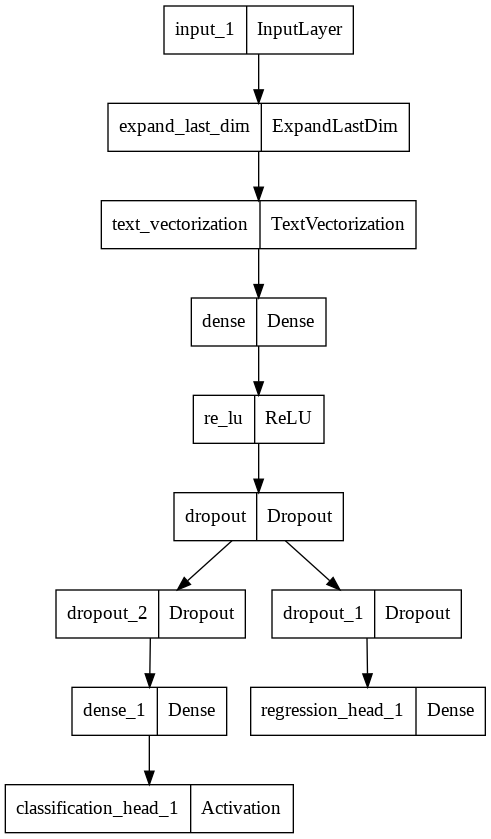

In [15]:
from tensorflow.keras.utils import plot_model
plot_model(model)